In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gp

In [2]:
def plot_polygons(ax, geoms, values=None, colormap='Set1', facecolor=None, edgecolor=None,
                            alpha=1.0, linewidth=1.0, **kwargs):
    # Makes a MatPlotLib PatchCollection out of Polygon and/or MultiPolygon geometries 
    # Thanks to http://stackoverflow.com/a/33753927
    import shapely
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Polygon
    
    patches = []
    newvals = []
    for polynum in range(len(geoms)):
        poly = geoms.iloc[polynum]
        if type(poly) != shapely.geometry.polygon.Polygon:
            for currpoly in poly.geoms:
                a = np.asarray(currpoly.exterior)
                patches.append(Polygon(a))
                if values is not None:
                    newvals.append(values.iloc[polynum])
        else:
            a = np.asarray(poly.exterior)
            patches.append(Polygon(a))
            if values is not None:
                newvals.append(values.iloc[polynum])

    patches = PatchCollection(patches, 
                              facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, alpha=alpha, 
                              **kwargs)
    if values is not None:
        patches.set_array(np.asarray(newvals))
        patches.set_cmap(colormap)
        norm = matplotlib.colors.Normalize()
        norm.autoscale(newvals)
        patches.set_norm(norm)
    ax.add_collection(patches, autolim=True)
    ax.set_aspect('equal')
    ax.autoscale_view()
    return patches


In [3]:
import os
os.chdir('/Users/dosullivan/Documents/teaching/Geog88/Labs/data')

In [170]:
counties = gp.read_file('ca-counties-2010.shp')
counties.head()

,CENSUSAREA,COUNTY,GEO_ID,Geography,Id,Id2,LSAD,NAME,STATE,f_medAge,...,pHLCuban,pHLMex,pHL_PR,pHLother,pHawPac,pHispLat,pMale,pOther,pU5,pWhite
0,4541.184,035,0500000US06035,"Lassen County, California",0500000US06035,6035.0,County,Lassen,06,40.9,...,0.1,12.1,0.3,5.1,0.5,17.5,64.2,10.2,4.7,73.2
1,3917.770,049,0500000US06049,"Modoc County, California",0500000US06049,6049.0,County,Modoc,06,46.9,...,0.0,11.8,0.0,2.0,0.2,13.9,50.4,7.0,5.6,83.5
2,46.873,075,0500000US06075,"San Francisco County, California",0500000US06075,6075.0,County,San Francisco,06,38.5,...,0.2,7.4,0.5,6.9,0.4,15.1,50.7,6.6,4.4,48.5
3,2735.085,083,0500000US06083,"Santa Barbara County, California",0500000US06083,6083.0,County,Santa Barbara,06,35.1,...,0.1,38.5,0.3,3.9,0.2,42.9,50.2,17.4,6.5,69.6
4,953.214,091,0500000US06091,"Sierra County, California",0500000US06091,6091.0,County,Sierra,06,51.5,...,0.2,6.7,0.1,1.4,0.1,8.3,50.8,2.3,4.5,93.3


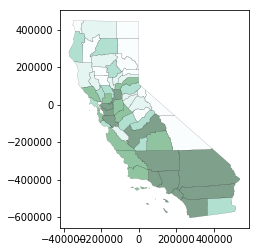

In [171]:
counties.plot(column="nPop", scheme="quantiles", cmap="BuGn", linewidth=0.1)

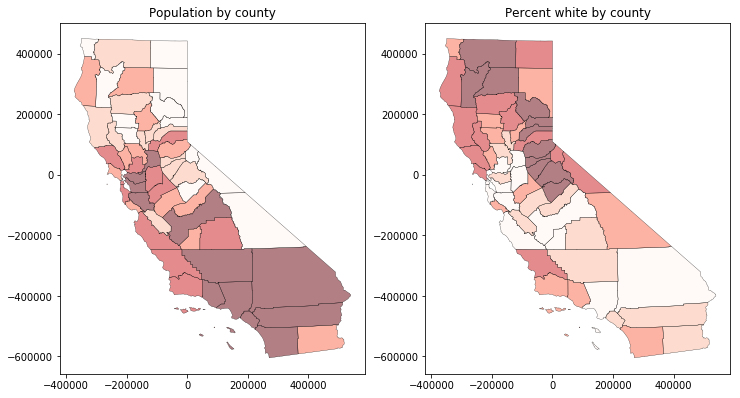

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.set_aspect('equal')
ax1.set_title('Population by county')
counties.plot(ax=ax1, column='nPop', linewidth=0.25, cmap='Reds', scheme="quantiles")
ax2.set_aspect('equal')
ax2.set_title('Percent white by county')
counties.plot(ax=ax2, column='pWhite', linewidth=0.25, cmap='Reds', scheme="quantiles")
plt.show()

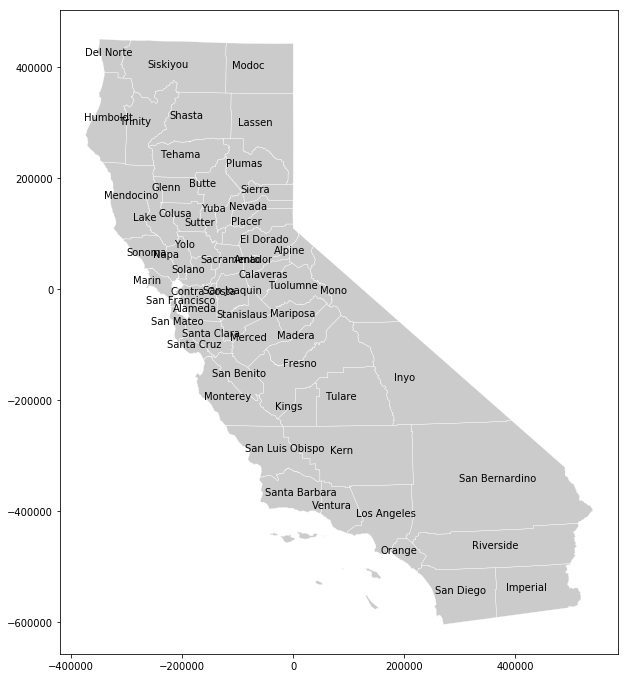

In [271]:
fig, ax = plt.subplots(figsize=(10,15))
ax.set_aspect('equal')
for p, t in zip(counties.geometry, counties.NAME):
    ax.annotate(xy=(p.centroid.x-50000, p.centroid.y), s=t)
counties.plot(ax=ax, color='#999999', linewidth=0.3, edgecolor='w')

In [226]:
election = gp.read_file("election-counties.geojson")
election.head()

,FID,dem,geometry,gop,grn,lib,name,oth,population,state,una
0,1001,5908,POLYGON ((-86.41301885555872 32.70736105750247...,18110,105,538,Autauga,0,54571,AL,0
1,1003,18409,POLYGON ((-87.76509377157363 31.29739947388194...,72780,453,2448,Baldwin,0,182265,AL,0
2,1005,4848,POLYGON ((-85.05591897303883 32.06305120967862...,5431,18,93,Barbour,0,27457,AL,0
3,1007,1874,POLYGON ((-86.88105859287846 33.04990077401541...,6733,17,124,Bibb,0,22915,AL,0
4,1009,2150,POLYGON ((-86.45285966141952 34.25929103860516...,22808,89,337,Blount,0,57322,AL,0


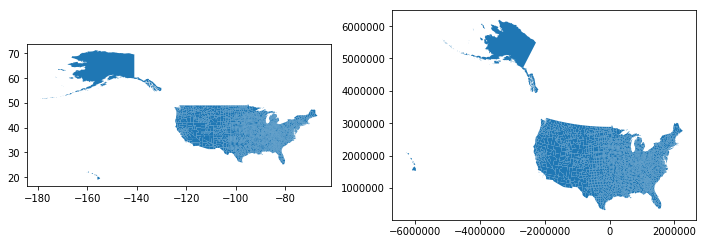

In [227]:
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plot_polygons(ax, election.geometry)

election_ea = election.to_crs(epsg=5070)
ax = plt.subplot(122)
plot_polygons(ax, election_ea.geometry)

In [229]:
election48 = election_ea[~election_ea['state'].isin(['AK', 'HI'])]
election48.to_file('election-counties-48.geojson', driver='GeoJSON')
election48 = gp.read_file('election-counties-48.geojson')

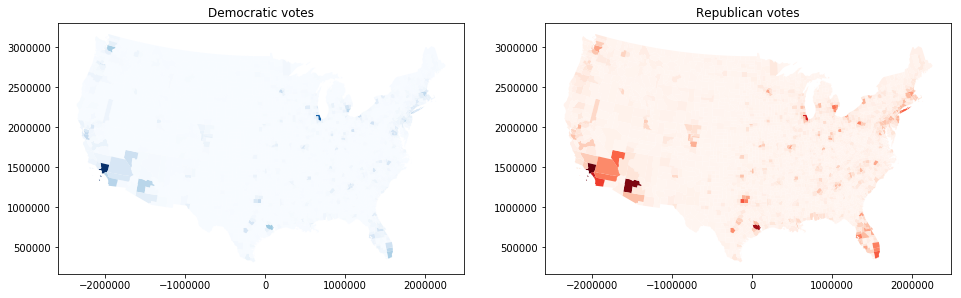

In [230]:
plt.figure(figsize=(16,8))
ax = plt.subplot(121)
ax.set_title('Democratic votes')
plot_polygons(ax, election48.geometry, values=election48.dem, colormap="Blues")
ax = plt.subplot(122)
ax.set_title('Republican votes')
plot_polygons(ax, election48.geometry, values=election48.gop, colormap="Reds")

In [235]:
election48['votes'] = election48.dem + election48.gop + election48.grn + election48.lib + election48.una + election48.oth
election48['goppc'] = election48.gop / election48.votes * 100
election48['dempc'] = election48.dem / election48.votes * 100

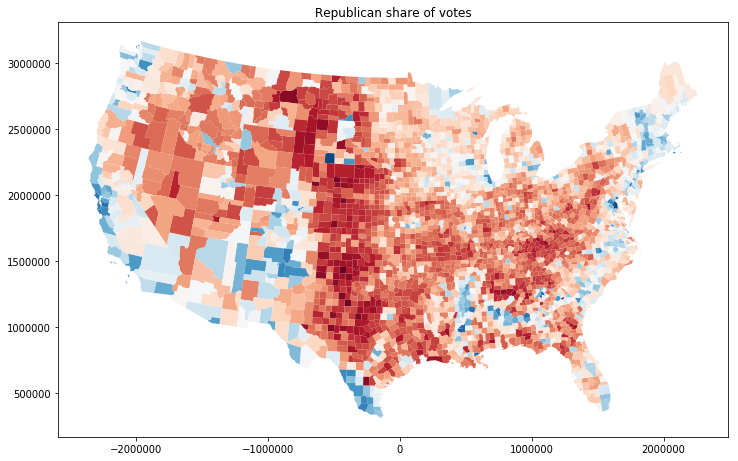

In [233]:
plt.figure(figsize=(12,9))
ax = plt.subplot(111)
ax.set_title('Republican share of votes')
plot_polygons(ax, election48.geometry, values=election48.goppc, colormap="RdBu_r")

In [249]:
states = election_ea.dissolve(by='state', aggfunc='sum', as_index=False)
states['votes'] = states.dem + states.gop + states.grn + states.lib + states.una + states.oth
states['dempc'] = states.dem / states.votes
states['goppc'] = states.gop / states.votes

In [250]:
states.head()

,state,geometry,FID,dem,gop,grn,lib,oth,population,una,votes,dempc,goppc
0,AK,(POLYGON ((-3371479.329734567 5045447.07581013...,2001,93007,130415,4445,14593,4128,710231,0,246588,0.377176,0.528878
1,AL,"POLYGON ((998843.1210250946 935438.8258693079,...",71489,718084,1306925,9287,43869,0,4779736,0,2078165,0.345538,0.628884
2,AR,"POLYGON ((439573.2907305224 1177002.465449736,...",380625,378729,677904,9837,29518,12627,2915918,0,1108615,0.341624,0.611487
3,AZ,POLYGON ((-1365876.729939255 1021579.408853245...,60208,936250,1021154,25255,80151,0,6392017,0,2062810,0.453871,0.495031
4,CA,(POLYGON ((-2077428.848194205 1354705.72972257...,351364,7230699,3841134,215694,394239,51757,37253956,0,11733523,0.616243,0.327364


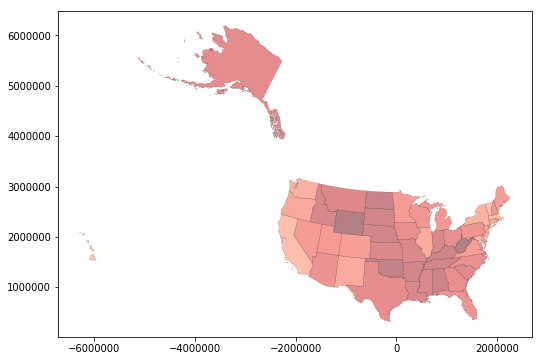

In [251]:
states.plot(column="goppc", cmap="Reds", figsize=(12,6), linewidth=0.1)

In [253]:
def get_max_idx(L):
    max_i = 0
    for i in range(len(L)):
        if L[i] >= L[max_i]:
            max_i = i
    return max_i

def remove_i(L, i):
    return L[:i] + L[i+1:]

def insert_i(L, i, x):
    return L[:i] + [x] + L[i:]

def apportion(pops, states, seats_to_assign=435, initial=1, extras=2, exclude='DC'):
    pops = list(pops)
    states = list(states)
    assigned = [initial] * len(pops)
    ex = states.index(exclude)
    assigned = remove_i(assigned, ex)
    pops = remove_i(pops, ex)
    remaining = seats_to_assign - sum(assigned)
    while remaining > 0:
        priorities = [p / np.sqrt(a * (a + 1)) for p, a in zip(pops, assigned)]
        max_priority = get_max_idx(priorities)
        assigned[max_priority] += 1
        remaining -= 1
    assigned = insert_i(assigned, ex, 1)
    assigned = [__ + 2 for __ in assigned]
    return assigned

In [283]:
states['ev'] = apportion(states.population, states.state)
states.head()

,state,geometry,FID,dem,gop,grn,lib,oth,population,una,votes,dempc,goppc,ev
0,AK,(POLYGON ((-3371479.329734567 5045447.07581013...,2001,93007,130415,4445,14593,4128,710231,0,246588,0.377176,0.528878,3
1,AL,"POLYGON ((998843.1210250946 935438.8258693079,...",71489,718084,1306925,9287,43869,0,4779736,0,2078165,0.345538,0.628884,9
2,AR,"POLYGON ((439573.2907305224 1177002.465449736,...",380625,378729,677904,9837,29518,12627,2915918,0,1108615,0.341624,0.611487,6
3,AZ,POLYGON ((-1365876.729939255 1021579.408853245...,60208,936250,1021154,25255,80151,0,6392017,0,2062810,0.453871,0.495031,11
4,CA,(POLYGON ((-2077428.848194205 1354705.72972257...,351364,7230699,3841134,215694,394239,51757,37253956,0,11733523,0.616243,0.327364,55


In [391]:
import pysal as ps
ps.version
neighbors = ps.weights.Contiguity.Rook.from_dataframe(election_ea)

/Users/dosullivan/anaconda/envs/py3/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 9 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/dosullivan/anaconda/envs/py3/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 67, 518, 519, 520, 521, 1191, 1197, 1841, 2930
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [392]:
neighbors[0]

{10: 1.0, 23: 1.0, 25: 1.0, 42: 1.0, 50: 1.0}

In [385]:
nss = []
for i, Ni in neighbors: 
    Ns = {}
    for j, w in Ni.items():
        Ns[j] = election_ea.state[j]
    nss.append((i, election_ea.state[i], Ns))
nss[:5]

[(0, 'AL', {10: 'AL', 23: 'AL', 25: 'AL', 42: 'AL', 50: 'AL'}),
 (1, 'AL', {12: 'AL', 26: 'AL', 48: 'AL', 49: 'AL', 64: 'AL', 307: 'FL'}),
 (2,
  'AL',
  {5: 'AL',
   22: 'AL',
   33: 'AL',
   54: 'AL',
   56: 'AL',
   388: 'GA',
   476: 'GA',
   486: 'GA'}),
 (3, 'AL', {10: 'AL', 32: 'AL', 36: 'AL', 52: 'AL', 58: 'AL', 62: 'AL'}),
 (4, 'AL', {21: 'AL', 27: 'AL', 36: 'AL', 47: 'AL', 57: 'AL', 63: 'AL'})]

In [386]:
boundary_pairs = []
boundary_cases = set()
for Ni in nss:
    i, i_s, Nj = Ni[0], Ni[1], Ni[2]
    for j, j_s in Nj.items():
        if i_s != j_s:
            boundary_pairs.append((i, j))
            boundary_cases = boundary_cases.union([i, j])


In [397]:
election['boundary'] = election.index.isin(boundary_cases)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_aspect('equal')
plot_polygons(ax=ax, geoms=election_ea.geometry)
plot_polygons(ax=ax, geoms=election_ea.geometry[np.where(election_ea.boundary)], facecolor='white')